In [1]:
import pandas as pd
import csv 
import geopandas as gpd
from datetime import timedelta
from shapely.geometry import Point
import glob
from shapely import wkt

/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#read csv files and adjust to datetime
R_im_date = pd.read_csv('../data/Ramsey/RamseyImageryDates.csv', parse_dates=['date'])
R_im_date['date'] = pd.to_datetime(R_im_date['date'])

#years = range(2015, 2025)
#pd.DataFrame([pd.Timestamp(year=year, month=6, day=15) for year in years], columns = ['date'])
R_sur_date = pd.read_csv('../data/Ramsey/RamseySurveyDates.csv', delimiter=';', index_col=False, parse_dates = ['Ramsey wet/dry date']) 
R_sur_date.rename(columns={'Ramsey wet/dry date':'date'}, inplace=True )
R_sur_date['date'] = pd.to_datetime(R_sur_date['date'], format = '%m/%d/%Y', errors = 'coerce')
R_sur_date = R_sur_date.dropna(subset = ['date'])

R_hyd = pd.read_csv('../data/Ramsey/RamseyHydroData.csv')
R_hyd.rename( columns={'Unnamed: 0':'date'}, inplace=True )
R_hyd['date'] = pd.to_datetime(R_hyd['date'])

R_precipitation = pd.read_csv('../data/Ramsey/daymet_precip.csv')
R_precipitation['system:time_start'] = pd.to_datetime(R_precipitation['system:time_start'])
R_precipitation.rename( columns={'00000000000000000000':'P','system:time_start':'day'}, inplace=True )

R_surveyData = pd.read_csv('../data/Ramsey/Ramsey_surveyData.csv')


In [3]:
#find matching dates between survey and imagery
matching_dates = []
tolerance = timedelta(days = 5)

for date1 in R_sur_date['date']:
    exact_date = False
    tol = False 
    for date2 in R_im_date['date']:
        if date1 == date2:
            matching_dates.append({'Survey': date1, 'Imagery': date2})
            exact_date = True
    if not exact_date:
        for date2 in R_im_date['date']:
            if abs(date1 - date2) <= tolerance:
                matching_dates.append({'Survey': date1, 'Imagery': date2})
                tol = True
        if not tol: 
            for date2 in R_im_date['date']:
                if abs(date1-date2) < timedelta(days = 10): 
                    matching_dates.append({'Survey': date1, 'Imagery': date2})


matching_df = pd.DataFrame(matching_dates)


In [4]:
R_datessurData = pd.merge(matching_df, R_hyd, left_on = 'Survey', right_on = 'date', how = 'left')
R_datesimData = pd.merge(matching_df, R_hyd, left_on = 'Imagery', right_on = 'date')
#R_datessurData = R_datessurData.drop(columns = ['Imagery','date'])
#R_datesimData = R_datesimData.drop(columns = ['Survey','date'])


In [5]:
#sum precipitation for dates in between survey and imagery
def sum_pdatesbetween(d1, d2):
    r = pd.date_range(start=min(d1,d2), end=max(d1,d2))
    return R_hyd[R_hyd['date'].isin(r)]['P [mm]'].sum()

In [6]:
#making a dataframe to determine which imagery dates to use
Rh = pd.DataFrame([])

Rh['Survey'] = matching_df['Survey']
Rh['Imagery'] = matching_df['Imagery']
Rh['sum_P'] = [sum_pdatesbetween(R_datessurData.loc[i, 'Survey'], R_datesimData.loc[i, 'Imagery']) for i in range(len(Rh))]
Rh['Q_s-i'] = (R_datessurData['Q [mm/d]'] - R_datesimData['Q [mm/d]']) / R_datessurData['Q [mm/d]'] * 100
Rh['Use/not'] = ['use', 'use', 'use', 'use', 'not', 'not',
                 'not', 'use', 'not', 'use'] 

Rh = Rh.fillna('')

conditions = (Rh['Use/not'] == 'not')

Rh = Rh[~conditions]

Rh = Rh.drop(columns=['Use/not'])

Rh

,Survey,Imagery,sum_P,Q_s-i
0,2018-06-23,2018-06-23,0.000000,
1,2019-06-15,2019-06-15,0.000000,0.0
2,2020-06-15,2020-06-15,0.931333,0.0
3,2021-06-16,2021-06-16,0.000000,
7,2022-06-12,2022-06-13,0.000000,
9,2023-06-13,2023-06-13,0.000000,0.0


In [7]:
Rh.to_csv('../data/Ramsey/Ramsey_survey_imagery_hydro.csv', index = 'False')

In [8]:
#merging a data frame to match the survey data to imagery dates
#First adjusting the dates in surveyData, only logged with the respective year and not exact date
R_sur_date['Year'] = R_sur_date['date'].dt.year
R_surveyData['Year'] = R_surveyData['Year'].astype(int)
Rdata = pd.merge(R_surveyData, R_sur_date[['date', 'Year']], on = 'Year', how = 'left')
Rdata = Rdata.drop(columns=['Year', 'Unnamed: 0'])
Rdata.rename(columns = {'date':'Year'}, inplace = True)
Rdata = Rdata.drop_duplicates()
Rdata

,geometry,wetdry,Year
0,POINT (565860.5239241327 3479495.202555806),dry,2020-06-15
1,POINT (565857.1538633622 3479491.508954528),dry,2020-06-15
2,POINT (565853.7838025916 3479487.81535325),dry,2020-06-15
3,POINT (565850.4137418212 3479484.121751971),dry,2020-06-15
4,POINT (565847.0436810507 3479480.428150693),dry,2020-06-15
...,...,...,...
13793,POINT (563918.7609584623 3476832.570563339),dry,2023-06-13
13794,POINT (563918.0300093086 3476837.516846118),dry,2023-06-13
13795,POINT (563917.2990601548 3476842.463128897),dry,2023-06-13
13796,POINT (563916.5681110012 3476847.409411677),dry,2023-06-13


In [9]:
#making the survey data with imagery dates into a geodataframe and adding x and y from the geometry to 
#facilitate merge

Rdata['geometry'] = Rdata['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(Rdata, geometry = 'geometry', crs='EPSG:26912')

gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y
gdf = gdf[['geometry', 'x', 'y', 'wetdry', 'Year']]
#gdf['Year'] = gdf['Year'].astype(int) 
#gdf['Year'] = pd.to_datetime(gdf['Year'])
gdf

,geometry,x,y,wetdry,Year
0,POINT (565860.524 3479495.203),565860.523924,3.479495e+06,dry,2020-06-15
1,POINT (565857.154 3479491.509),565857.153863,3.479492e+06,dry,2020-06-15
2,POINT (565853.784 3479487.815),565853.783803,3.479488e+06,dry,2020-06-15
3,POINT (565850.414 3479484.122),565850.413742,3.479484e+06,dry,2020-06-15
4,POINT (565847.044 3479480.428),565847.043681,3.479480e+06,dry,2020-06-15
...,...,...,...,...,...
13793,POINT (563918.761 3476832.571),563918.760958,3.476833e+06,dry,2023-06-13
13794,POINT (563918.03 3476837.517),563918.030009,3.476838e+06,dry,2023-06-13
13795,POINT (563917.299 3476842.463),563917.299060,3.476842e+06,dry,2023-06-13
13796,POINT (563916.568 3476847.409),563916.568111,3.476847e+06,dry,2023-06-13


In [10]:
#Checking for perennial reaches by comparing surveys of each year
perennial = pd.DataFrame(gdf.groupby('geometry')['wetdry'].apply(lambda x: sum(x == 'wet'))).reset_index(drop=False)

# whichever number is reasonable based on data?
perennial = perennial[(perennial['wetdry'] == 6)]

#assume always wet
perennial = perennial.assign(wetdry = 'wet')

#perennial['geometry'] = perennial['geometry'].apply(wkt.loads)
gdf_perennial = gpd.GeoDataFrame(perennial, geometry = 'geometry', crs='EPSG:26912')
gdf_perennial['x'] = gdf_perennial.geometry.x
gdf_perennial['y'] = gdf_perennial.geometry.y

#making the gdf matching the perennial reaches to the imagery dates available 
imagery_perennial = pd.concat([gdf_perennial.assign(imagery = date) for date in R_im_date['date']], ignore_index=True)
imagery_perennial = imagery_perennial[~imagery_perennial['imagery'].isin(Rh['Imagery'])]
imagery_perennial['assumption'] = len(imagery_perennial)*['assumed perennial']
imagery_perennial

,geometry,wetdry,x,y,imagery,assumption
0,POINT (563350.778 3476892.462),wet,563350.777523,3.476892e+06,2016-07-22,assumed perennial
1,POINT (563355.191 3476890.112),wet,563355.190922,3.476890e+06,2016-07-22,assumed perennial
2,POINT (563377.258 3476878.363),wet,563377.257917,3.476878e+06,2016-07-22,assumed perennial
3,POINT (563372.845 3476880.713),wet,563372.844518,3.476881e+06,2016-07-22,assumed perennial
4,POINT (563368.431 3476883.063),wet,563368.431119,3.476883e+06,2016-07-22,assumed perennial
...,...,...,...,...,...,...
8115,POINT (563377.258 3476878.363),wet,563377.257917,3.476878e+06,2024-03-28,assumed perennial
8116,POINT (563372.845 3476880.713),wet,563372.844518,3.476881e+06,2024-03-28,assumed perennial
8117,POINT (563368.431 3476883.063),wet,563368.431119,3.476883e+06,2024-03-28,assumed perennial
8118,POINT (563364.018 3476885.413),wet,563364.017720,3.476885e+06,2024-03-28,assumed perennial


<Axes: >

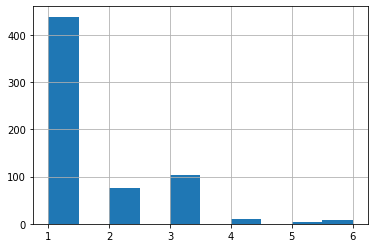

In [11]:
filtered_gdf = gdf[gdf['wetdry'] == 'wet']
filtered_gdf.groupby('geometry').count().wetdry.hist()

In [12]:
# merging to be able to use the new precipitation data
R_new_hyd = R_hyd.merge( R_precipitation, left_on = 'date', right_on = 'day')
R_new_hyd = R_new_hyd.drop(columns = ['day', 'P [mm]'])
R_new_hyd.rename( columns={'P':'P [mm]'}, inplace=True )
R_new_hyd.set_index(['date'], drop =True, inplace = True)
R_new_hyd

,Q [mm/d],P [mm]
date,,
2016-01-01,0.000481,0.00
2016-01-02,0.000481,0.00
2016-01-03,0.000481,0.00
2016-01-04,0.000682,16.30
2016-01-05,0.000662,4.45
...,...,...
2023-12-27,0.000000,0.00
2023-12-28,0.000000,0.00
2023-12-29,0.000000,0.00


In [13]:
#function to define assumptions around dates to choose, based on streamflow and precipitation
def tolerance(Q_P_data, date, start, adjust, tolerance_p, P_condition = -999, Q_condition = -999):
    
    sub_grupp = Q_P_data.copy()
    
    if adjust == 'start':      
        sub_grupp = Q_P_data.loc[start:].copy()       
        
    elif adjust == 'end': #reverse index to loop backwards
        sub_grupp = sub_grupp.loc[:start].copy().iloc[::-1]        
    
    else:
        print('Invalid adjust parameter. Please use "start" or "end"')
        return

    
    # Reset index if reversed
    sub_grupp.reset_index(inplace=True)
     
    sub_grupp['Q_diff'] = sub_grupp['Q [mm/d]'].diff().fillna(0)

    if adjust == 'start':
        sub_grupp['tolerance_condition'] = (sub_grupp.Q_diff < tolerance_p * sub_grupp['Q [mm/d]'])

    if adjust == 'end':
        sub_grupp['tolerance_condition'] = (sub_grupp.Q_diff > -tolerance_p * sub_grupp['Q [mm/d]'])
    
    if P_condition == -999 == Q_condition:
        print('not a valid condition')
        return 
        
    elif P_condition == -999:
        if Q_condition > 0:
            sub_grupp['condition'] = sub_grupp['Q [mm/d]'] > Q_condition
        else:
            sub_grupp['condition'] = sub_grupp['Q [mm/d]'] < -Q_condition
            
    elif Q_condition == -999:
        if P_condition > 0:
            sub_grupp['condition'] = sub_grupp['P [mm]'] > P_condition
        else:
            sub_grupp['condition'] = sub_grupp['P [mm]'] < -P_condition
            
    else:
        if (Q_condition > 0) & (P_condition > 0):
            sub_grupp['condition'] = (sub_grupp['Q [mm/d]'] > Q_condition) & (sub_grupp['P [mm]'] > P_condition)
        elif (Q_condition < 0) & (P_condition > 0):
            sub_grupp['condition'] = (sub_grupp['Q [mm/d]'] < -Q_condition) & (sub_grupp['P [mm]'] > P_condition)           
        elif (Q_condition > 0) & (P_condition < 0):
            sub_grupp['condition'] = (sub_grupp['Q [mm/d]'] > Q_condition) & (sub_grupp['P [mm]'] < -P_condition)            
        else:
            sub_grupp['condition'] = (sub_grupp['Q [mm/d]'] < -Q_condition) & (sub_grupp['P [mm]'] < -P_condition)

    #where conditions are met
    yesgroup = sub_grupp[(sub_grupp['condition'] == True) & (sub_grupp['tolerance_condition'] == True)] 
       
  
    if len(yesgroup) == 0:
        print('No data where conditions are met')
        return pd.DataFrame()
        
    #where conditions are not met
    nogroup = sub_grupp[(sub_grupp['condition'] == False) | (sub_grupp['tolerance_condition'] == False)]  
    
    if len(nogroup) == 0:
        print('nogroup = 0')
        return sub_grupp.loc[yesgroup.index[0]:]

    if yesgroup.index[0] < nogroup.index[0]:
        print('everything is fine')
        return sub_grupp.loc[:nogroup.index[0]]
    
    else:
        print('No valid range found between yesgroup and nogroup indices')
        return pd.DataFrame()




In [14]:
#assumption of dry dates after the survey date


dry_list = []

for date in Rdata['Year'].unique():
    dry1 = tolerance(R_new_hyd, 'date', date, 'start', 0.05, Q_condition = -999, P_condition = -1)
    if len(dry1) == 0:
        print('dry1 is empty')
        continue
    dry1 = dry1[~dry1['date'].isin(Rh['Imagery'])]
    dry_imagery = pd.merge(dry1, R_im_date, on = ['date'], how = 'inner')
    #print(len(dry_imagery))
    dry_points = pd.DataFrame(gdf[gdf['Year']== (date)] .groupby('geometry')['wetdry'].apply(lambda x: (x == 'dry'))).reset_index(drop = False)
    dry_points = dry_points.assign(wetdry = 'dry')
    dry_im_points = [dry_points.assign(imagery = date) for date in dry_imagery['date']]
    #print(len(dry_im_points))
    
    try:
        dry = pd.concat(dry_im_points).drop(columns = ['level_1'])
        dry_list.append(dry)
    except:
        if len(dry_im_points)==0:
            print('No data for date '+ date.strftime('%Y-%m-%d'))
        else:
            dry = dry_im_points[0]
            dry_list.append(dry)
    #print(len(dry))
    

dry_df = pd.concat(dry_list)
dry_df['assumption'] = len(dry_df)*['assumed dry']




No valid range found between yesgroup and nogroup indices
dry1 is empty
everything is fine
No data for date 2016-06-21
everything is fine
No data for date 2014-06-19
everything is fine
No data for date 2009-06-15
No valid range found between yesgroup and nogroup indices
dry1 is empty
everything is fine
No data for date 2012-06-13
everything is fine
No data for date 2015-06-15
No valid range found between yesgroup and nogroup indices
dry1 is empty
everything is fine
No data for date 2013-06-11
No valid range found between yesgroup and nogroup indices
dry1 is empty
everything is fine
No data for date 2010-06-10
everything is fine
everything is fine


In [15]:

gdf['assumption'] = len(gdf)*['survey/imagery match']
gdf_imagery = pd.merge(gdf, Rh, left_on = 'Year', right_on = 'Survey', how = 'left')
gdf_imagery = gdf_imagery.drop(columns=['Survey', 'sum_P', 'Q_s-i', 'Year'])
all_expanded = pd.concat([gdf_imagery, imagery_perennial, dry_df])
all_expanded = gpd.GeoDataFrame(all_expanded, geometry = 'geometry', crs='EPSG:26912')
all_expanded['x'] = all_expanded.geometry.x
all_expanded['y'] = all_expanded.geometry.y
all_expanded = all_expanded.rename(columns = {'imagery':'date_first'})
all_expanded['date'] = all_expanded['Imagery'].combine_first(all_expanded['date_first'])
all_expanded

,geometry,x,y,wetdry,assumption,Imagery,date_first,date
0,POINT (565860.524 3479495.203),565860.523924,3.479495e+06,dry,survey/imagery match,2020-06-15,NaT,2020-06-15
1,POINT (565857.154 3479491.509),565857.153863,3.479492e+06,dry,survey/imagery match,2020-06-15,NaT,2020-06-15
2,POINT (565853.784 3479487.815),565853.783803,3.479488e+06,dry,survey/imagery match,2020-06-15,NaT,2020-06-15
3,POINT (565850.414 3479484.122),565850.413742,3.479484e+06,dry,survey/imagery match,2020-06-15,NaT,2020-06-15
4,POINT (565847.044 3479480.428),565847.043681,3.479480e+06,dry,survey/imagery match,2020-06-15,NaT,2020-06-15
...,...,...,...,...,...,...,...,...
983,POINT (564364.063 3477361.63),564364.062568,3.477362e+06,dry,assumed dry,NaT,2023-07-08,2023-07-08
984,POINT (564362.24 3477356.974),564362.240233,3.477357e+06,dry,assumed dry,NaT,2023-07-08,2023-07-08
985,POINT (564360.418 3477352.318),564360.417899,3.477352e+06,dry,assumed dry,NaT,2023-07-08,2023-07-08
986,POINT (564358.596 3477347.662),564358.595564,3.477348e+06,dry,assumed dry,NaT,2023-07-08,2023-07-08


In [16]:
#reading and concatenating the processed imagery 
path = '../data/Ramsey/processed_imagery'

processed_imagery = glob.glob(path + '/*.csv')
processed_imagery.sort(key = lambda x: int(x.split('_buffer_')[1].split('.')[0]))

con_ready_imagery = []
for processed in processed_imagery:
    df= pd.read_csv(processed)
    con_ready_imagery.append(df)

concatenated = pd.concat(con_ready_imagery)

In [21]:
#turning the processed imagery into a gdf with x and y columns 
concatenated['geometry'] = concatenated['geometry'].apply(wkt.loads)
gdf_processed = gpd.GeoDataFrame(concatenated, geometry = 'geometry', crs='EPSG:26912')
gdf_processed['date'] = pd.to_datetime(gdf_processed['date'], format='%Y%m%d')
gdf_processed['x'] = gdf_processed.geometry.x
gdf_processed['y'] = gdf_processed.geometry.y

In [30]:
gdf_processed = gdf_processed.drop_duplicates()
gdf_processed = gdf_processed.dropna()
gdf_processed = gdf_processed.groupby(['date','x','y']).first()

In [34]:
precision = 5
gdf_processed.reset_index(inplace=True)
all_expanded['x'] = all_expanded['x'].round(precision)
all_expanded['y'] = all_expanded['y'].round(precision)
gdf_processed['x'] = gdf_processed['x'].round(precision)
gdf_processed['y'] = gdf_processed['y'].round(precision)

In [20]:
#merged = all_expanded.merge(gdf2, on=['date', 'x', 'y'])
#merged['geometry'] = merged['geometry'].apply(wkt.loads)
#merged = gpd.GeoDataFrame(merged, geometry = 'geometry', crs='EPSG:26912')
#merged['x'] = merged.geometry.x
#merged['y'] = merged.geometry.y


In [35]:
merged = all_expanded.merge(gdf_processed, on=['date', 'x', 'y'])
if len(merged) == 0:
    print("Merge returned empty. Doing a spatial join based on proximity.")
    # Perform a nearest spatial join
    result = gpd.sjoin_nearest(all_expanded, gdf_processed, how='inner', max_distance=0.4)  # Adjust max_distance as needed
    result = result[result['date_left'] == result['date_right']]
    result = result.drop(columns = ['geometry', 'x_right', 'y_right', 'date_right', 'index_right', 'Imagery', 'date_first'])

Merge returned empty. Doing a spatial join based on proximity.


/var/folders/9h/qhym8j_x3vlby3c3j9klp0vc0000gn/T/ipykernel_52036/2063056035.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:26912
Right CRS: None

  result = gpd.sjoin_nearest(all_expanded, gdf_processed, how='inner', max_distance=0.4)  # Adjust max_distance as needed


In [36]:
result = result.rename(columns = {'x_left':'x', 'y_left':'y', 'date_left':'date'})
result_sorted = result.sort_values(by='date')

In [37]:
result_sorted = result_sorted.drop_duplicates()
result_sorted.dropna(inplace = True)
result_sorted

,x,y,wetdry,assumption,date,blue,green,red,NIR,missing,NDWI,p
0,563350.77752,3.476892e+06,wet,assumed perennial,2016-07-22,206.44,461.22,587.78,2945.67,0,-0.73,0
1,563355.19092,3.476890e+06,wet,assumed perennial,2016-07-22,176.78,432.67,564.89,2828.56,0,-0.73,0
2,563377.25792,3.476878e+06,wet,assumed perennial,2016-07-22,232.11,474.44,606.33,2779.78,0,-0.71,0
3,563372.84452,3.476881e+06,wet,assumed perennial,2016-07-22,223.89,462.11,592.78,2686.78,0,-0.71,0
4,563368.43112,3.476883e+06,wet,assumed perennial,2016-07-22,143.67,372.33,505.89,2596.11,0,-0.75,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8115,563377.25792,3.476878e+06,wet,assumed perennial,2024-03-28,265.00,534.89,609.11,2331.11,0,-0.63,0
8116,563372.84452,3.476881e+06,wet,assumed perennial,2024-03-28,262.11,512.22,568.78,2275.11,0,-0.63,0
8117,563368.43112,3.476883e+06,wet,assumed perennial,2024-03-28,225.67,442.00,525.00,2007.56,0,-0.64,0
8118,563364.01772,3.476885e+06,wet,assumed perennial,2024-03-28,201.22,389.89,476.00,1866.22,0,-0.65,0


In [38]:
result_sorted.to_csv('../data/Ramsey/processed_assumptions/processed_with_dates_and_assumptions.csv', encoding='utf-8', index=False)

In [ ]:
#in case geometry gets fixed and the file increases in size as a result 
#start = 0
#splitnum = ?
#for i in range(1,splitnum+1):
#    newstart = int(len(result_sorted)/splitnum*i)
#    result_sorted.iloc[start:newstart].to_csv('../data/Ramsey/processed_assumptions/processed_with_dates_and_assumptions'+str(i)+'.csv',index=False,
#                      float_format='%.2f')
#    start = newstart



Text(0, 0.5, '# points')

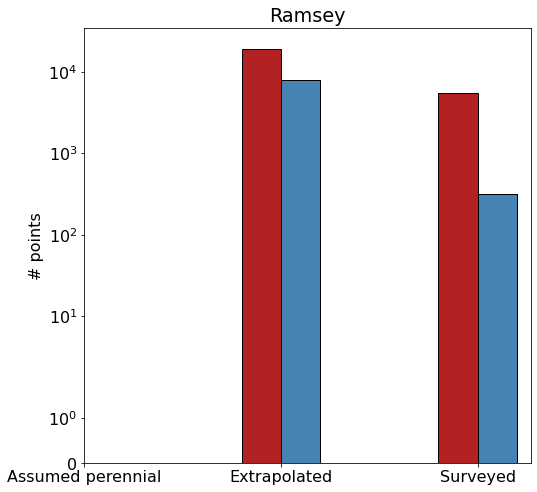

In [48]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import matplotlib.pyplot as plt
details = result_sorted.groupby(['wetdry','assumption']).count()['date'].reset_index()
fig,ax = plt.subplots(1,figsize = (8,8))
ax.bar([1,2],[details.date.values[0],details.date.values[1]],width=.2,
       facecolor = 'firebrick',edgecolor = 'k')
ax.bar([1.2,2.2],[details.date.values[i] for i in range(2,4)],width=.2,
       facecolor='steelblue',edgecolor = 'k')
ax.set_yscale('symlog')
ax.set_xticks([.1,1.1,2.1],['Assumed perennial','Extrapolated','Surveyed',])
ax.set_title('Ramsey')
ax.set_ylabel('# points')

In [43]:
details

,wetdry,assumption,date
0,dry,assumed dry,19480
1,dry,survey/imagery match,5605
2,wet,assumed perennial,7908
3,wet,survey/imagery match,312
